# Supervised Pretraining, End-to-End Fine-Tuning

<a id="1-import-modules"></a>
## 1 Import Modules

In [1]:
from torch.utils.data import Dataset, DataLoader
import os
import pickle
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from EncoderCNN import Encoder
from ConvRNN import ConvLSTM
from Decoder import Decoder
from torchvision.utils import make_grid
import torch.optim as optim
from tqdm import tqdm
from MotionEncoder import MotionEncoder
from CameraEncoder import CameraEncoder
from RNN import EgoMotionRNN
from CameraDecoder import CameraDecoder
from DepthMap import DepthDecoder
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import random
from PIL import ImageDraw, ImageFilter
import torch.nn.functional as F
from IPython.display import HTML

<a id="2-datasets"></a>
## 2 Datasets

In [2]:
root_dataset_path = '/home/user/asifa0/Project/CARLABase'                        

<a id="21-transforms"></a>
### 2.1 Transforms

In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

In [4]:
def transform_segmentation_target(image):
    """
    Transform a segmentation image to a tensor with class labels based on the red channel encoding.
    """
    img_array = np.array(image, dtype=np.int64)
    label = img_array[:, :, 0]  # Extract the red channel as the label

    # Map the red channel to class labels based on the dataset's specifications
    label_map = {
    0: 0,   # Unlabeled
    1: 1,   # Building
    2: 2,   # Fence
    3: 3,   # Other
    4: 4,   # Pedestrian
    5: 5,   # Pole
    6: 6,   # RoadLine
    7: 7,   # Road
    8: 8,   # SideWalk
    9: 9,   # Vegetation
    10: 10, # Vehicles
    11: 11, # Wall
    12: 12, # TrafficSign
    13: 13, # Sky
    14: 14, # Ground
    15: 15, # Bridge
    16: 16, # RailTrack
    17: 17, # GuardRail
    18: 18, # TrafficLight
    19: 19, # Static
    20: 20, # Dynamic
    21: 21, # Water
    22: 22, # Terrain
}
    label_tensor = torch.from_numpy(np.vectorize(label_map.get)(label))

    return label_tensor

In [5]:
target_transform = transforms.Compose([
    transforms.Resize((256, 512)), 
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Lambda(lambda img: transform_segmentation_target(img)),
])

In [6]:
depth_transform = transforms.Compose([
    transforms.Resize((256, 512)), 
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  
    # Normalize depth values if necessary. This is just an example; adjust according to your depth data range.
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

<a id="22-functions-to-corrupt-base-carla"></a>
### 2.2 Functions to Corrupt BASE CARLA

In [7]:
def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 0.1
    sigma = var ** 0.05
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)  
    return noisy.astype(np.uint8)  

def add_clutter(image):
    draw = ImageDraw.Draw(image)
    number_of_shapes = random.randint(1, 5)  
    for _ in range(number_of_shapes):
        x1, y1 = random.randint(0, image.size[0] - 1), random.randint(0, image.size[1] - 1)
        x2, y2 = random.randint(0, image.size[0] - 1), random.randint(0, image.size[1] - 1)
        draw.line((x1, y1, x2, y2), fill='white', width=2)
    return image

def change_illumination(image):
    new_image = image.astype(np.float64) * (0.6 + np.random.random() * 0.8)  
    new_image = np.clip(new_image, 0, 255)  
    return new_image.astype(np.uint8)  

def add_motion_blur(image, angle, radius):
    # Apply motion blur to the image using PIL's ImageFilter.
    image = image.filter(ImageFilter.GaussianBlur(radius=radius))
    return image.rotate(angle, resample=Image.BICUBIC).filter(ImageFilter.GaussianBlur(radius)).rotate(-angle, resample=Image.BICUBIC)

def add_low_light_effect(image, factor):
    # Multiply the image with a factor to simulate low light conditions.
    new_image = image.astype(np.float64) * factor  
    new_image = np.clip(new_image, 0, 255)
    return new_image.astype(np.uint8)

def add_overexposure_effect(image, factor):
    # Add a constant value to simulate overexposure.
    new_image = image.astype(np.float64) + factor * 255  
    new_image = np.clip(new_image, 0, 255)
    return new_image.astype(np.uint8)


<a id="23-dataset-directory-iteration-logic-class"></a>
### 2.3 Dataset Directory Iteration logic Class

In [8]:
class SequentialImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, depth_transform=None, apply_corruption=False, include_towns=None, exclude_towns=None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform 
        self.depth_transform = depth_transform 
        self.include_towns = include_towns
        self.exclude_towns = exclude_towns
        self.sequences = self._load_sequences()
        self.apply_corruption = apply_corruption

    def _load_sequences(self):
        sequences = []
        for town in sorted(os.listdir(self.root_dir)):
            
            if self.include_towns and town not in self.include_towns:
                continue
            if self.exclude_towns and town in self.exclude_towns:
                continue
            town_path = os.path.join(self.root_dir, town)
            if os.path.isdir(town_path):
                for sequence in sorted(os.listdir(town_path)):
                    sequence_path = os.path.join(town_path, sequence)
                    if os.path.isdir(sequence_path):
                        
                        # Filter files to include only those that match the expected pattern
                        valid_files = [f for f in os.listdir(sequence_path) if f.startswith('img_') and f.endswith('.png') and any(char.isdigit() for char in f)]
                        if valid_files:
                            
                            # Sort the files based on the numeric part of the filename
                            images = sorted(valid_files, key=lambda f: int(''.join(filter(str.isdigit, f))))
                            images = [os.path.join(sequence_path, f) for f in images]
                            sequences.append(images)
        return sequences

    def __len__(self):
        return len(self.sequences)
    

    def __getitem__(self, idx):
        image_paths = self.sequences[idx]
        optical_flow_paths = [p.replace('img_', 'optical_flow_').replace('.png', '.npy') for p in image_paths]
        segmentation_paths = [p.replace('img_', 'segmentation_') for p in image_paths]
        depth_paths = [p.replace('img_', 'depth_') for p in image_paths]
        sequence_tensors = []
        segmentation_tensors = []
        depth_tensors = []
        optical_flow_tensors = []
        
        # Load input Images and optical_flow files
        for image_path, optical_flow_path in zip(image_paths, optical_flow_paths):
            try:
                img = Image.open(image_path).convert('RGB')
                if self.apply_corruption:
                    img = np.array(img)
                    img = add_gaussian_noise(img)
                    # Overexposure effect
                    factor = random.uniform(0.1, 0.3)
                    img = add_overexposure_effect(np.array(img), factor)
                    img = Image.fromarray(img, 'RGB') 
                    #img = add_clutter(img)
                    # Apply motion blur
                    angle = random.uniform(0, 0.5)
                    radius = random.uniform(2, 6)
                    img = np.array(img)
                    img = add_motion_blur(Image.fromarray(img), angle, radius)
                    img = np.array(img)  
                    img = change_illumination(img)
                    img = Image.fromarray(img, 'RGB')
                if self.transform:
                    img = self.transform(img)
                sequence_tensors.append(img)
                optical_flow = np.load(optical_flow_path)
                optical_flow_tensor = torch.from_numpy(optical_flow).permute(2, 0, 1) # Assuming optical flow has shape (H, W, 2)
                optical_flow_tensors.append(optical_flow_tensor)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                sequence_tensors.append(torch.zeros((3, 256, 512)))
                optical_flow_tensors.append(torch.zeros((2, 256, 512)))

        
        # Load camera extrinsics for the sequence
        meta_path = os.path.join(os.path.dirname(image_paths[0]), 'meta.pkl')
        with open(meta_path, 'rb') as f:
            meta_data = pickle.load(f)
        extrinsics = torch.tensor(meta_data['extrinsics'][:6], dtype=torch.float32)
        
        # Segmented images loading
        
        for seg_path in segmentation_paths:
            try:
                with Image.open(seg_path) as seg:
                    if self.target_transform:
                        seg = self.target_transform(seg)
                    segmentation_tensors.append(seg)
            except Exception as e:
                print(f"Error loading segmentation image {seg_path}: {e}")
                
        # Load depth maps
        for depth_path in depth_paths:
            try:
                with Image.open(depth_path) as depth:
                    if self.depth_transform:
                        depth = self.depth_transform(depth)
                    depth_tensors.append(depth)
            except Exception as e:
                print(f"Error loading depth image {depth_path}: {e}")
                

        sequence_tensor = torch.stack(sequence_tensors) if sequence_tensors else torch.zeros((6, 3, 256, 512))
        optical_flow_tensor = torch.stack(optical_flow_tensors) if optical_flow_tensors else torch.zeros((6, 2, 256, 512))
        depth_tensor = torch.stack(depth_tensors) if depth_tensors else torch.zeros((6, 1, 256, 512))
        segmentation_tensor = torch.stack(segmentation_tensors) if segmentation_tensors else torch.zeros((6, 23, 256, 512))

        return sequence_tensor, optical_flow_tensor, segmentation_tensor, extrinsics, depth_tensor



<a id="24-base-carla"></a>
### 2.4 BASE CARLA

In [9]:
# Initialize the dataset for training, validation, and testing
org_train_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=False, exclude_towns=['Town02', 'Town10'])
org_val_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=False, include_towns=['Town02'])
org_test_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=False, include_towns=['Town10'])

<a id="25-corrupted-carla"></a>
### 2.5 Corrupted CARLA

In [10]:
# Initialize the dataset for training, validation, and testing
train_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=True, exclude_towns=['Town02', 'Town10'])
val_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=True, include_towns=['Town02'])
test_dataset = SequentialImagesDataset(root_dataset_path, transform=transform, target_transform=target_transform, depth_transform=depth_transform, apply_corruption=True, include_towns=['Town10'])

<a id="3-dataloader"></a>
## 3 Dataloader

In [11]:
# DataLoaders for each set
org_train_loader = DataLoader(org_train_dataset, batch_size=1, shuffle=False, num_workers=4)
org_val_loader = DataLoader(org_val_dataset, batch_size=1, shuffle=False, num_workers=4)
org_test_loader = DataLoader(org_test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [12]:
# DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

<a id="31-dataset-inspection"></a>
### 3.1 Dataset Inspection

In [13]:
print( f'Length of Train Loader: {len(train_loader)}')
for sequence_tensor, optical_flow, segmentation_tensor, extrinsics, depth_tensor in train_loader:
    print(f'Shape of Input Images: {sequence_tensor.shape}')
    print(f'Shape of OpticalFlow tensors: {optical_flow.shape}')
    print(f'Shape of Segmented Images: {segmentation_tensor.shape}') 
    print(f'Shape of extrinsics tensor: {extrinsics.shape}')
    print(f'Shape of Depth Images: {depth_tensor.shape}')
    
    break 
    

Length of Train Loader: 8982
Shape of Input Images: torch.Size([1, 6, 3, 256, 512])
Shape of OpticalFlow tensors: torch.Size([1, 6, 2, 512, 1024])
Shape of Segmented Images: torch.Size([1, 6, 256, 512])
Shape of extrinsics tensor: torch.Size([1, 6, 4, 4])
Shape of Depth Images: torch.Size([1, 6, 1, 256, 512])


<a id="32-visualising-whole-sequence-of-both-datasets"></a>
### 3.2 Visualising whole sequence of Both Datasets

In [14]:

def visualize_sequence(sequence_tensor, rows=2, cols=3):
    sequence_length = sequence_tensor.size(0)
    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i in range(rows * cols):
        ax = axs[i // cols, i % cols]      
        if i < sequence_length:
            img_tensor = sequence_tensor[i]
            img = np.transpose(img_tensor.numpy(), (1, 2, 0))
            ax.imshow(img)
            ax.set_title(f"Frame {i+1}", fontsize=10)
        ax.axis('off') 
    
    plt.tight_layout()
    plt.show()

Base Carla Images


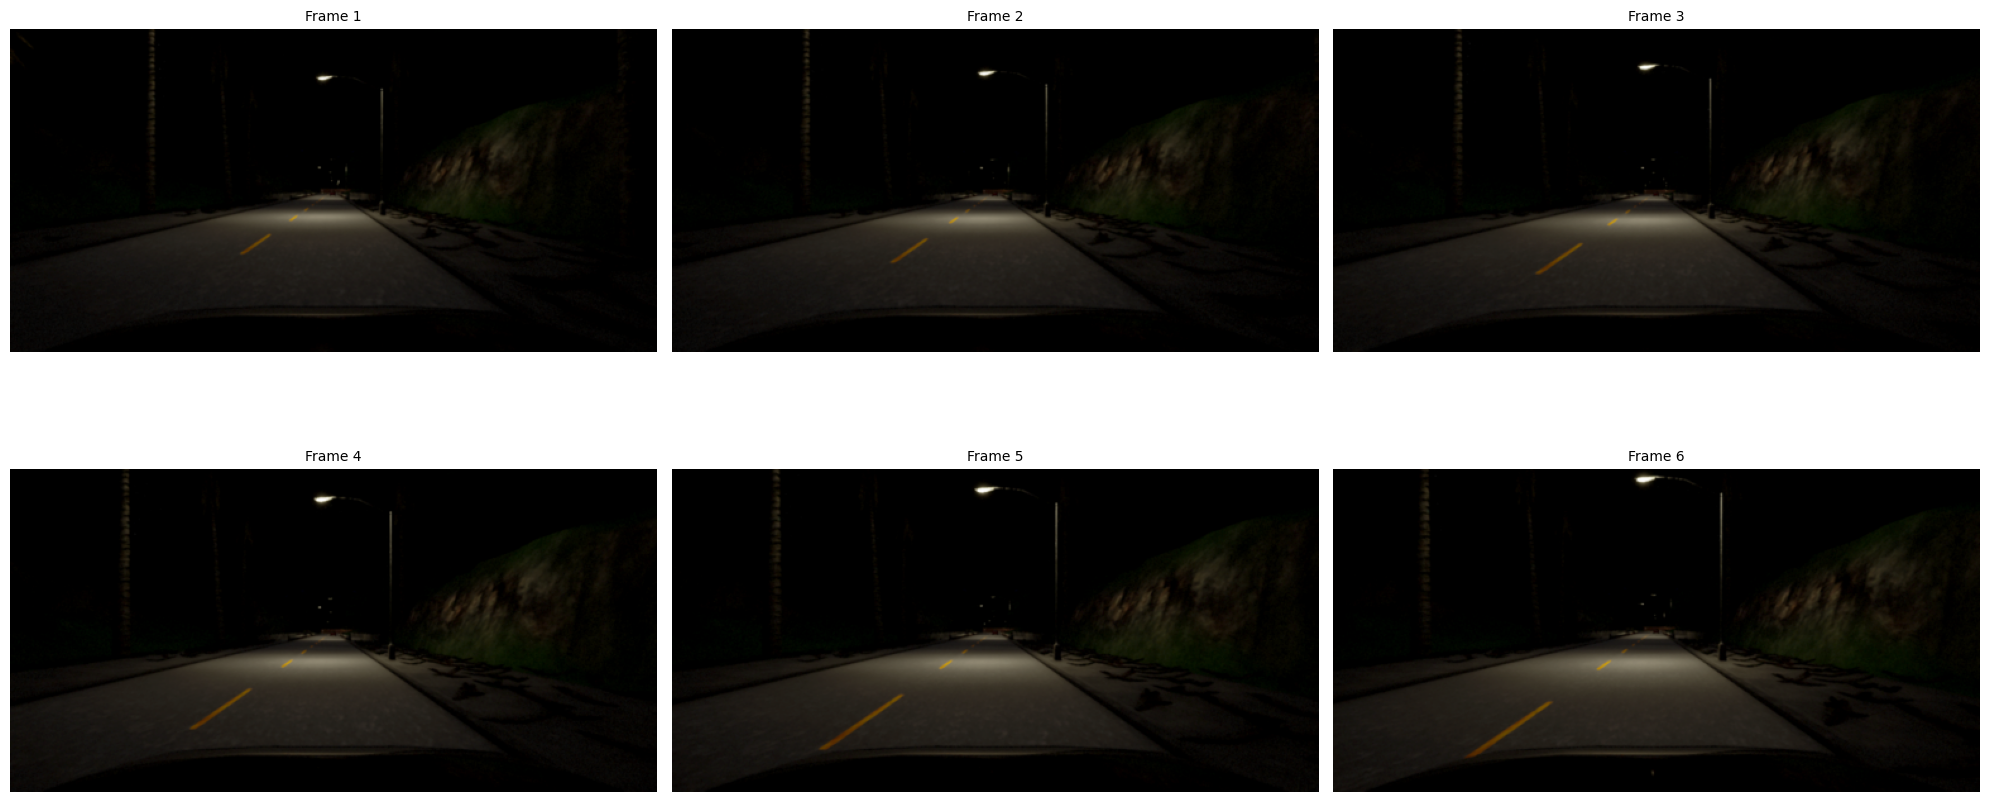

Corrupted Carla Images


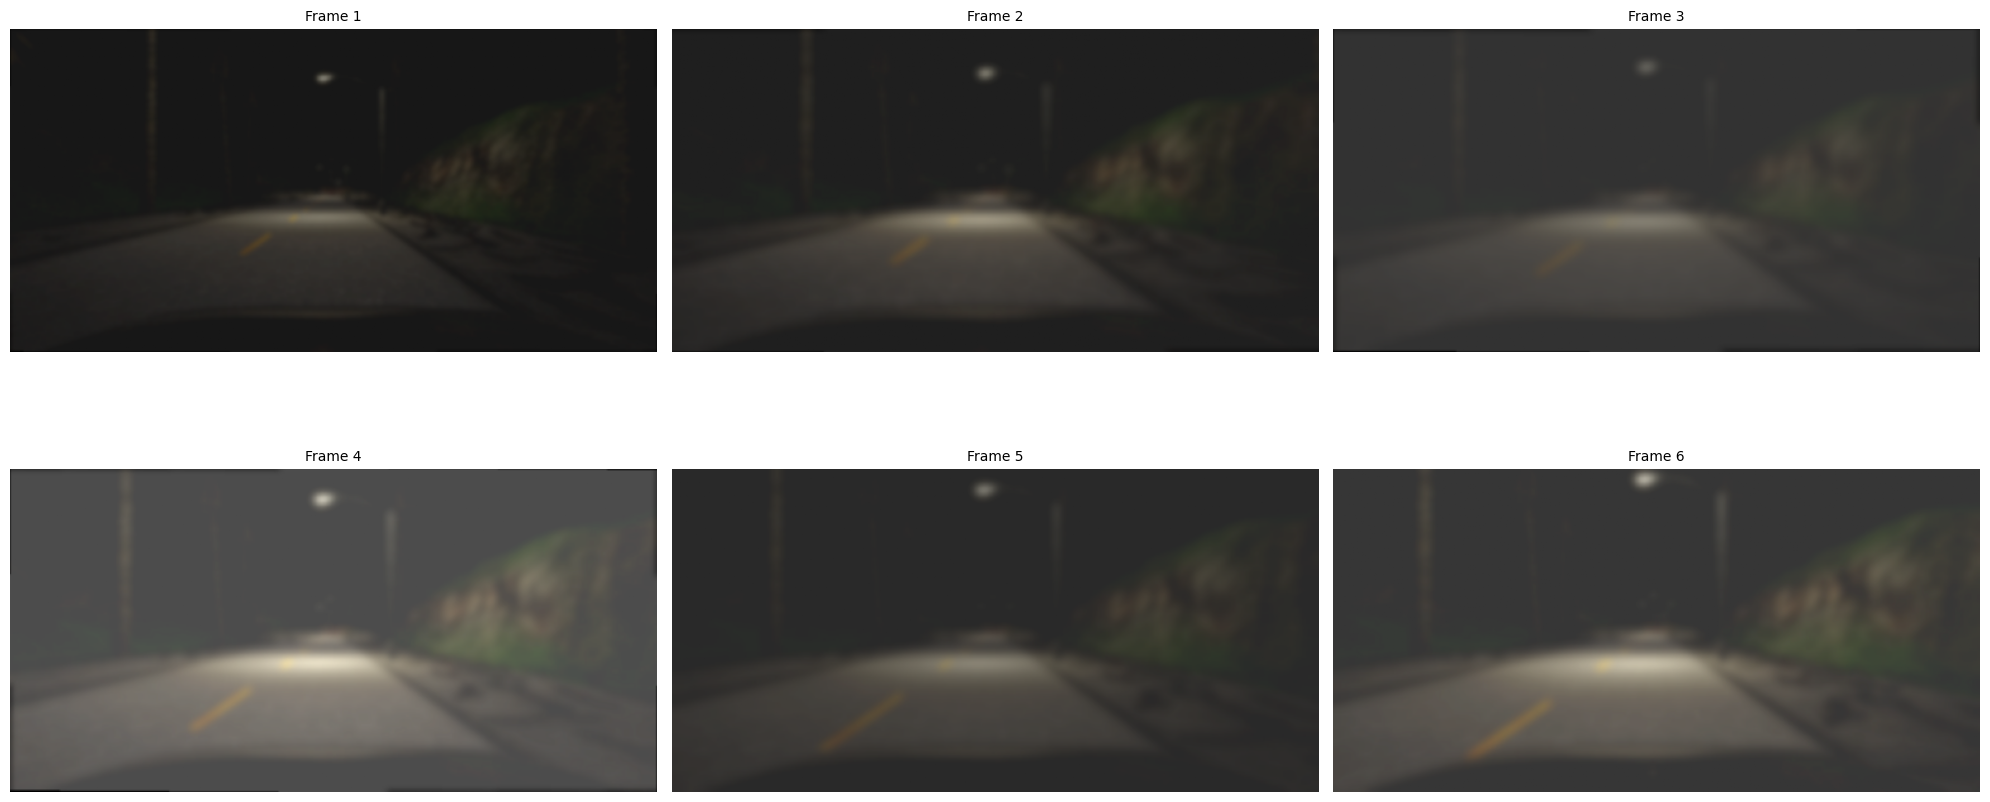

In [15]:

print("Base Carla Images")
for org_batch_idx, (org_sequence_tensors, org_optical_flow, org_segmentation_tensors, org_extrinsics, org_depth_tensor) in enumerate(org_train_loader):
    if org_batch_idx == 1:  # Choose the second sequence by setting the index to 1, or any other index you wish to visualize
        org_first_sequence_tensor = org_sequence_tensors[0] 

        # Check if the tensor contains non-zero data
        if torch.any(org_first_sequence_tensor):
            # Now visualize this sequence
            visualize_sequence(org_first_sequence_tensor, rows=2, cols=3)
        else:
            print(f"The tensor for sequence at index {batch_idx} contains only zeros or is not loaded correctly.")

        break 
print("Corrupted Carla Images")
for batch_idx, (sequence_tensors, optical_flow, segmentation_tensors, extrinsics, depth_tensor) in enumerate(train_loader):
    if batch_idx == 1:  # Choose the second sequence by setting the index to 1, or any other index you wish to visualize
        first_sequence_tensor = sequence_tensors[0] 

        # Check if the tensor contains non-zero data
        if torch.any(first_sequence_tensor):
            # Now visualize this sequence
            visualize_sequence(first_sequence_tensor, rows=2, cols=3)
        else:
            print(f"The tensor for sequence at index {batch_idx} contains only zeros or is not loaded correctly.")

        break  


<a id="4-training-device"></a>
## 4 Training Device

In [16]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<a id="5-utils"></a>
## 5 Utils

<a id="51-segmentation-maps-coloring-function"></a>
### 5.1 Segmentation Maps Coloring Function

In [17]:
def decode_segmap(label_mask, n_classes=23):
    """
    Decode segmentation class labels into a color image.
    """
    label_colors = np.array([
        (0, 0, 0),        # Unlabeled
        (70, 70, 70),     # Building
        (100, 40, 40),    # Fence
        (55, 90, 80),     # others
        (220, 20, 60),    # Pedestrian
        (153, 153, 153),  # Pole
        (157, 234, 50),   # RoadLine
        (128, 64, 128),   # Road
        (244, 35, 232),   # SideWalk
        (107, 142, 35),   # Vegetation
        (0, 0, 142),      # Vehicles
        (102, 102, 156),  # Wall
        (220, 220, 0),    # TrafficSign
        (70, 130, 180),   # Sky
        (81, 0, 81),      # Ground
        (150, 100, 100),  # Bridge
        (230, 150, 140),  # RailTrack
        (180, 165, 180),  # GuardRail
        (250, 170, 30),   # TrafficLight
        (110, 190, 160),  # Static
        (170, 120, 50),   # Dynamic
        (45, 60, 150),    # Water
        (145, 170, 100),  # Terrain
        (255, 255, 255),  # ignore_index=22
    ])

    r = np.zeros_like(label_mask).astype(np.uint8)
    g = np.zeros_like(label_mask).astype(np.uint8)
    b = np.zeros_like(label_mask).astype(np.uint8)

    for l in range(0, n_classes):
        idx = label_mask == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb


<a id="52-evaluation-metric-functions"></a>
### 5.2 Evaluation Metric Functions

In [18]:
def calculate_mAcc(preds, targets):
    max_preds = preds.argmax(dim=1, keepdim=True)  
    correct_pred = max_preds.squeeze(1).eq(targets)
    acc_per_class = []

    for class_idx in range(targets.max() + 1):
        correct = correct_pred[targets == class_idx].sum()
        total = (targets == class_idx).sum()
        if total != 0:
            acc_per_class.append(correct.float() / total)

    mAcc = torch.mean(torch.stack(acc_per_class)) if acc_per_class else torch.tensor(0)
    return mAcc.item()


def calculate_mIoU(predicted_classes, target_classes, num_classes, device='cpu'):
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)

    for class_idx in range(num_classes):
        intersection_mask = (predicted_classes == class_idx) & (target_classes == class_idx)
        union_mask = (predicted_classes == class_idx) | (target_classes == class_idx)
        
        intersection[class_idx] = intersection_mask.sum()
        union[class_idx] = union_mask.sum()

    # Avoid division by zero
    union[union == 0] = 1
    iou = intersection / union
    mIoU = iou.mean().item()
    return mIoU

<a id="53-functions-to-bring-camera-poses-to-same-scale-as-ground-truths-scale"></a>
### 5.3 Functions to bring Camera Poses to same scale as ground truth's scale

In [19]:
def calculate_distances(poses):
    distances = torch.sqrt(torch.sum((poses[0, 1:, :3, 3] - poses[0, :-1, :3, 3]) ** 2, axis=1))
    return distances.cpu().detach().numpy()

def analyze_translations(original_poses, predicted_poses):
    # Compute statistics
    original_distances = calculate_distances(original_poses)
    predicted_distances = calculate_distances(predicted_poses)

    # Compute statistics
    statistics = {
        "original": {
            "mean_distance": np.mean(original_distances),
            "std_distance": np.std(original_distances),
            "max_distance": np.max(original_distances),
            "min_distance": np.min(original_distances),
        },
        "predicted": {
            "mean_distance": np.mean(predicted_distances),
            "std_distance": np.std(predicted_distances),
            "max_distance": np.max(predicted_distances),
            "min_distance": np.min(predicted_distances),
        }
    }
    return statistics

<a id="54-function-to-visualise-all-ground-truths-and-generated-images-for-comparison"></a>
### 5.4 Function to Visualise all ground truths and generated images For comparison

In [20]:

def visualize_sequence_full(sequence_batch, segmentation_targets, predicted_segmentation, depth_tensor, predicted_depth, device):
    batch_size, sequence_length, c, h, w = sequence_batch.size()

    for i in range(sequence_length):
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))
        
        # Input image
        axes[0].imshow(sequence_batch[0, i].permute(1, 2, 0).cpu().numpy())
        axes[0].set_title('Input Image')

        # Ground truth segmentation
        gt_segmap = decode_segmap(segmentation_targets[0, i].cpu().numpy())
        axes[1].imshow(gt_segmap)
        axes[1].set_title('Ground Truth Segmentation')

        # Predicted segmentation
        pred_segmap = decode_segmap(predicted_segmentation[i].cpu().numpy())
        axes[2].imshow(pred_segmap)
        axes[2].set_title('Predicted Segmentation')

        # Ground truth depth map
        axes[3].imshow(depth_tensor[0, i].squeeze().cpu().numpy(), cmap='gray')
        axes[3].set_title('Ground Truth Depth Map')

        # Predicted depth map
        axes[4].imshow(predicted_depth[0, i].squeeze().cpu().detach().numpy(), cmap='gray')
        axes[4].set_title('Predicted Depth Map')

        plt.show()


<a id="55-function-to-generate-gifs"></a>
### 5.5 Function to Generate GIFs

In [21]:
import imageio
import numpy as np
import torch
import os

def save_gif(image_sequence, filename, duration=10):
    with imageio.get_writer(filename, mode='I', duration=duration, loop=0) as writer:
        for image in image_sequence:
           
            if image.dtype != np.uint8:
                image = (255.0 * image).astype(np.uint8)
            writer.append_data(image)

<a id="56-function-to-plot-camera-poses"></a>
### 5.6 Function to Plot Camera Poses

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_camera_trajectories(original_poses, predicted_poses):
    # Extract the translation components from original and predicted poses
    original_translations = original_poses[0, :, :3, 3].cpu().detach().numpy()
    predicted_translations = predicted_poses[0, :, :3, 3].cpu().detach().numpy()

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the original trajectory
    ax.plot(original_translations[:, 0], original_translations[:, 1], original_translations[:, 2], 
            marker='o', color='red', label='Original Poses')

    # Plot the predicted trajectory
    ax.plot(predicted_translations[:, 0], predicted_translations[:, 1], predicted_translations[:, 2], 
            marker='^', color='blue', label='Predicted Poses')

    # Label each pose in the original trajectory
    for i, t in enumerate(original_translations):
        ax.text(t[0], t[1], t[2], f'O{i}', color='red')

    # Label each pose in the predicted trajectory
    for i, t in enumerate(predicted_translations):
        ax.text(t[0], t[1], t[2], f'P{i}', color='blue')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Camera Pose Trajectories')
    ax.legend()

    plt.show()

<a id="6-architecture-components-initialization"></a>
## 6 Architecture Components Initialization

In [23]:
%run EncoderCNN.ipynb
%run ConvRNN.ipynb
%run Decoder.ipynb
%run MotionEncoder.ipynb
%run CameraEncoder.ipynb
%run RNN.ipynb
%run CameraDecoder.ipynb
%run DepthMap.ipynb

<a id="61-models-initializing"></a>
### 6.1 Models Initializing

In [24]:
# Encoder
encoder = Encoder()
print(encoder)

# ConvLSTM parameters
input_channels = 64 
hidden_channels = 64  
kernel_size = 3  
stride = 1  
conv_lstm_model = ConvLSTM(in_channels=input_channels,
                           hidden_channels=hidden_channels,
                           kernel_size=kernel_size,
                           stride=stride,)
print(conv_lstm_model)

# Depth Decoder
depth_decoder = DepthDecoder(input_channels=64, depth_channels=1)
print(depth_decoder)

# Decoder Parameters:
num_classes =23
in_channels = 64
out_channels = 23
decoder = Decoder(in_channels, out_channels)
print(decoder)

# Motion Encoder
motion_in_channels = 66  
motion_hidden_channels = 64  
motion_kernel_size = 3  
motion_encoder = MotionEncoder(motion_in_channels, motion_hidden_channels, motion_kernel_size)
print(motion_encoder)

# Camera Encoder
camera_encoder = CameraEncoder(input_channels=64)
print(camera_encoder)

# RNN
hidden_size = 64  
output_size = 16  
ego_motion_rnn = EgoMotionRNN(hidden_size, output_size)
print(ego_motion_rnn)

# Camera Decoder
camera_decoder = CameraDecoder(input_size=16, hidden_size=36)
print(camera_decoder)

Encoder(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
ConvLSTM(
  (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
DepthDecoder(
  (upsample1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (upsample2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (depth_conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Decoder(
  (up1): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (

<a id="62-optimizer"></a>
### 6.2 Optimizer

In [25]:
# Optimizer
import torch.nn as nn
optimizer = optim.Adam(list(encoder.parameters()) + list(conv_lstm_model.parameters()) + list(depth_decoder.parameters()) + list(decoder.parameters()) + list(motion_encoder.parameters()) + list(camera_encoder.parameters()) + list(ego_motion_rnn.parameters())+ list(camera_decoder.parameters()), lr=3e-4)


<a id="63-criterions"></a>
### 6.3 Criterions

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=22)
Cam_criterion = nn.MSELoss()

def Depth_criterian(predicted, true):
    min_value = 1e-8
    predicted_clamped = torch.clamp(predicted, min=min_value)
    true_clamped = torch.clamp(true, min=min_value)
    log_predicted = torch.log(predicted_clamped)
    log_true = torch.log(true_clamped)
    loss = F.l1_loss(log_predicted, log_true)
    return loss

In [27]:
torch.cuda.empty_cache()

<a id="7-Experiments"></a>
## 7 Experiments

<a id="71-No-Filters-Model"></a>
### 7.1 No Filters Model

<a id="711-training-loop"></a>
#### 7.1.1 Training Loop

In [39]:
class SegmentationModelTrainer:
    def __init__(self, encoder, conv_lstm, depth_decoder, decoder, motion_encoder, camera_encoder, ego_motion_rnn, camera_decoder, org_train_loader, org_val_loader, train_loader, val_loader, criterion, Cam_criterion, Depth_criterian, optimizer, device):
        self.encoder = encoder
        self.conv_lstm_model = conv_lstm
        self.depth_decoder = depth_decoder
        self.decoder = decoder
        self.motion_encoder = motion_encoder
        self.camera_encoder = camera_encoder
        self.ego_motion_rnn = ego_motion_rnn
        self.camera_decoder = camera_decoder
        self.org_train_loader = org_train_loader
        self.org_val_loader = org_val_loader
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.Cam_criterion = Cam_criterion
        self.Depth_criterian = Depth_criterian
        self.optimizer = optimizer
        self.device = device

        # Move models to the specified device
        self.encoder.to(device)
        self.conv_lstm_model.to(device)
        self.depth_decoder.to(device)
        self.decoder.to(device)
        self.motion_encoder.to(device)
        self.camera_encoder.to(device)
        self.ego_motion_rnn.to(device)
        self.camera_decoder.to(device)
        
    def switch_dataloader(self, mode):
        if mode == 'pretraining':
            self.train_loader = self.org_train_loader
            self.val_loader = self.org_val_loader
        elif mode == 'fine_tuning':
            self.train_loader = self.train_loader  # This should probably be a different loader for corrupted data
            self.val_loader = self.val_loader

    def train_epoch(self, epoch, mode):
        self.encoder.train()
        self.conv_lstm_model.train()
        self.depth_decoder.train()
        self.decoder.train()
        self.motion_encoder.train()
        self.camera_encoder.train()
        self.ego_motion_rnn.train()
        self.camera_decoder.train()
        
        self.switch_dataloader(mode)        

        seg_losses = []
        depth_losses = []
        cam_losses = []
        total_losses = []
        previous_features = None
        
        for sequence_batch, optical_flow_batch, segmentation_targets, extrinsics, depth_tensor in tqdm(self.train_loader, desc="Training"):
            
            sequence_batch = sequence_batch.to(self.device)
            optical_flow_batch = optical_flow_batch.to(self.device)
            segmentation_targets = segmentation_targets.to(self.device)
            extrinsics = extrinsics.to(self.device)
            depth_tensor = depth_tensor.to(self.device)
            
            sequence_length = sequence_batch.size(1)
            batch_size = sequence_batch.size(0)
            
            depth_tensor = depth_tensor[0, :, :, :, :]
            
            # Process segmentation targets as needed before using them as model inputs
            segmentation_targets = self._process_segmentation_targets(segmentation_targets)

            self.optimizer.zero_grad()
            
            encoder_outputs = []
            motion_features_list = []

            for t in range(sequence_length):
                img_t = sequence_batch[:, t, :, :, :] 
                optical_flow_t = optical_flow_batch[:, t, :, :, :] 
                # ENCODER
                encoder_output_t = self.encoder(img_t)  
                encoder_outputs.append(encoder_output_t)

                # MOTION ENCODER
                motion_features_t = self.motion_encoder(encoder_output_t, optical_flow_t)
                motion_features_list.append(motion_features_t)
                

            # After processing all time steps, stack the outputs
            encoder_output = torch.stack(encoder_outputs, dim=1)
            motion_encoder = torch.stack(motion_features_list, dim=1)
            
            # Camera Encoder
            motion_encoder = motion_encoder[0, :, :, :, :]
            camera_encoder_output_t = self.camera_encoder(motion_encoder)
            
            # Doing dimentionality reduction 
            camera_encoder_output_t = camera_encoder_output_t.mean(dim=0, keepdim=True)
            camera_encoder_output_flat = camera_encoder_output_t.view(batch_size, sequence_length, -1)  
            if mode == 'fine_tuning':
                # RNN
                extrinsics_flat = extrinsics.view(batch_size, sequence_length, -1) 
                combined_input = torch.cat((camera_encoder_output_flat, extrinsics_flat), dim=2)  
                ego_motion_output = self.ego_motion_rnn(combined_input)

                # CAMERA DECODER
                ego_motion_output = ego_motion_output[:, -1, :]
                camera_poses = self.camera_decoder(ego_motion_output)
            
            elif mode == 'pretraining':
                # CAMERA DECODER
                camera_encoder_output_flat = camera_encoder_output_flat[:, 0, :]
                camera_poses = self.camera_decoder(camera_encoder_output_flat)
            
            # Calculate the scaling factor based on the means of the original and predicted distances
            stats = analyze_translations(extrinsics, camera_poses)
            scaling_factor = stats['original']['mean_distance'] / stats['predicted']['mean_distance']

            # Apply the scaling factor to the translations of the predicted camera poses
            camera_poses_scaled = camera_poses.clone() 
            camera_poses_scaled[:, :, :3, 3] *= scaling_factor
            
            if mode == 'fine_tuning':
                # Hidden Layer_org
                batch_size, seq_length, channels, height, width = encoder_output.size()
                hidden_state, cell_state = self.conv_lstm_model.init_hidden(batch_size, height, width)

                # ConvLSTM
                conv_lstm_output, (hidden_state, cell_state) = self.conv_lstm_model(encoder_output, (hidden_state.to(self.device), cell_state.to(self.device)))
                batch_size, seq_length, channels, height, width = conv_lstm_output.size()
                conv_lstm_output = conv_lstm_output.view(batch_size * seq_length, channels, height, width)

                # DEPTH DECODER
                depth_decoder_output = self.depth_decoder(conv_lstm_output)

                # Decoder
                decoder_output = self.decoder(conv_lstm_output)
            elif mode == 'pretraining':
                # DEPTH DECODER
                encoder_output = encoder_output[0, :, :, :, :]
                depth_decoder_output = self.depth_decoder(encoder_output)

                # Decoder
                decoder_output = self.decoder(encoder_output)
            
            # Backpropagation for Segmentation Loss
            seg_loss = self.criterion(decoder_output, segmentation_targets)
            seg_losses.append(seg_loss.item())

            # Backpropagation for Depth Loss
            depth_loss = self.Depth_criterian(depth_decoder_output, depth_tensor)
            depth_losses.append(depth_loss.item())

            # Backpropagation for Camera Pose Loss
            cam_loss = self.Cam_criterion(camera_poses_scaled, extrinsics)
            cam_losses.append(cam_loss.item())
            
            # Total Losses
            total_loss = seg_loss + depth_loss + cam_loss
            self.optimizer.zero_grad()           
            total_loss.backward()
            self.optimizer.step()
            total_losses.append(total_loss.item())
            
            #writer.add_scalar('Loss/Train/Segmentation', seg_loss.item(), global_step=epoch * len(self.train_loader) + batch_idx)
            #writer.add_scalar('Loss/Train/Depth', depth_loss.item(), global_step=epoch * len(self.train_loader) + batch_idx)
            #writer.add_scalar('Loss/Train/Camera', cam_loss.item(), global_step=epoch * len(self.train_loader) + batch_idx)

        # Save all models here
        model_save_path = 'Models/NoFilter'  
        if not os.path.exists(model_save_path):
            os.makedirs(model_save_path)

        torch.save(self.encoder.state_dict(), os.path.join(model_save_path, f'Encoder.pth'))
        torch.save(self.conv_lstm_model.state_dict(), os.path.join(model_save_path, f'ConvLSTM.pth'))
        torch.save(self.depth_decoder.state_dict(), os.path.join(model_save_path, f'DepthDecoder.pth'))
        torch.save(self.decoder.state_dict(), os.path.join(model_save_path, f'SegmentationDecoder.pth'))
        torch.save(self.motion_encoder.state_dict(), os.path.join(model_save_path, f'MotionEncoder.pth'))
        torch.save(self.camera_encoder.state_dict(), os.path.join(model_save_path, f'CameraEncoder.pth'))
        torch.save(self.ego_motion_rnn.state_dict(), os.path.join(model_save_path, f'EgoMotionRNN.pth'))
        torch.save(self.camera_decoder.state_dict(), os.path.join(model_save_path, f'CameraDecoder.pth'))
        
        # converting lists to tensors to calculate means
        seg_losses_tensor = torch.tensor(seg_losses)
        depth_losses_tensor = torch.tensor(depth_losses)
        cam_losses_tensor = torch.tensor(cam_losses)
        total_losses_tensor = torch.tensor(total_losses)

        # Calculating means
        mean_seg_loss = torch.mean(seg_losses_tensor).item()
        mean_depth_loss = torch.mean(depth_losses_tensor).item()
        mean_cam_loss = torch.mean(cam_losses_tensor).item()
        mean_total_loss = torch.mean(total_losses_tensor).item()
        
        return mean_seg_loss, mean_depth_loss, mean_cam_loss, mean_total_loss

        
    @torch.no_grad()
    def validate_epoch(self, epoch, mode):
        self.encoder.eval()
        self.conv_lstm_model.eval()
        self.depth_decoder.eval()
        self.decoder.eval()
        self.motion_encoder.eval()
        self.camera_encoder.eval()
        self.ego_motion_rnn.eval()
        self.camera_decoder.eval()
        
        self.switch_dataloader(mode)

        seg_val_losses = []
        cam_val_losses = []
        depth_val_losses = []
        val_total_losses = []
        mAccs = []
        val_mIoUs = []
        previous_features = None
        
        for val_sequence_batch, val_optical_flow_batch, val_segmentation_targets, val_extrinsics, val_depth_tensor in tqdm(self.val_loader, desc="Validation"):
            
            val_sequence_batch = val_sequence_batch.to(self.device)
            val_segmentation_targets = val_segmentation_targets.to(self.device)
            val_optical_flow_batch = val_optical_flow_batch.to(self.device)
            val_extrinsics = val_extrinsics.to(self.device)
            val_depth_tensor = val_depth_tensor.to(self.device)

            # Flatten the sequence and batch dimensions
            sequence_length = val_sequence_batch.size(1)
            batch_size = val_sequence_batch.size(0)
            val_depth_tensor = val_depth_tensor[0, :, :, :, :]
            
            # Process segmentation targets as needed before using them as model inputs
            val_segmentation_targets = self._process_segmentation_targets(val_segmentation_targets)
                  
            encoder_outputs = []
            motion_features_list = []
            
            for t in range(sequence_length):
                img_t = val_sequence_batch[:, t, :, :, :] 
                optical_flow_t = val_optical_flow_batch[:, t, :, :, :] 
                # ENCODER
                encoder_output_t = self.encoder(img_t)  
                encoder_outputs.append(encoder_output_t)

                # MOTION ENCODER
                motion_features_t = self.motion_encoder(encoder_output_t, optical_flow_t)
                motion_features_list.append(motion_features_t)
                

            # After processing all time steps, stack the outputs
            encoder_output = torch.stack(encoder_outputs, dim=1)
            motion_encoder = torch.stack(motion_features_list, dim=1)
            
            # Camera Encoder
            motion_encoder = motion_encoder[0, :, :, :, :]
            camera_encoder_output_t = self.camera_encoder(motion_encoder)
            
            
            # Doing dimentionality reduction 
            camera_encoder_output_t = camera_encoder_output_t.mean(dim=0, keepdim=True)
            camera_encoder_output_flat = camera_encoder_output_t.view(batch_size, sequence_length, -1) 
            if mode == 'fine_tuning':
                # RNN
                extrinsics_flat = val_extrinsics.view(batch_size, sequence_length, -1) 
                combined_input = torch.cat((camera_encoder_output_flat, extrinsics_flat), dim=2)  
                ego_motion_output = self.ego_motion_rnn(combined_input)

                # CAMERA DECODER
                ego_motion_output = ego_motion_output[:, -1, :]
                camera_poses = self.camera_decoder(ego_motion_output)
                #camera_poses = camera_poses.view(-1, 4, 4)
            elif mode == 'pretraining':
                # CAMERA DECODER
                camera_encoder_output_flat = camera_encoder_output_flat[:, 0, :]
                camera_poses = self.camera_decoder(camera_encoder_output_flat)
            
            # Calculate the scaling factor based on the means of the original and predicted distances
            stats = analyze_translations(val_extrinsics, camera_poses)
            scaling_factor = stats['original']['mean_distance'] / stats['predicted']['mean_distance']

            # Apply the scaling factor to the translations of the predicted camera poses
            camera_poses_scaled = camera_poses.clone() 
            camera_poses_scaled[:, :, :3, 3] *= scaling_factor
            
            if mode == 'fine_tuning':
                # Hidden Layer_org
                batch_size, seq_length, channels, height, width = encoder_output.size()
                hidden_state, cell_state = self.conv_lstm_model.init_hidden(batch_size, height, width)

                # ConvLSTM
                conv_lstm_output, (hidden_state, cell_state) = self.conv_lstm_model(encoder_output, (hidden_state.to(self.device), cell_state.to(self.device)))
                batch_size, seq_length, channels, height, width = conv_lstm_output.size()
                conv_lstm_output = conv_lstm_output.view(batch_size * seq_length, channels, height, width)

                # DEPTH DECODER
                depth_decoder_output = self.depth_decoder(conv_lstm_output)

                # Decoder
                decoder_output = self.decoder(conv_lstm_output)
            elif mode == 'pretraining':
                # DEPTH DECODER
                encoder_output = encoder_output[0, :, :, :, :]
                depth_decoder_output = self.depth_decoder(encoder_output)

                # Decoder
                decoder_output = self.decoder(encoder_output)   
            
            
            mAcc = calculate_mAcc(decoder_output, val_segmentation_targets)
            mAccs.append(mAcc)
            
            predicted_classes = torch.argmax(decoder_output, dim=1)
            mIoU = calculate_mIoU(predicted_classes, val_segmentation_targets, num_classes, self.device)
            val_mIoUs.append(mIoU)

            seg_val_loss = self.criterion(decoder_output, val_segmentation_targets)
            seg_val_losses.append(seg_val_loss.item())

            depth_val_loss = self.Depth_criterian(depth_decoder_output, val_depth_tensor)
            depth_val_losses.append(depth_val_loss.item())

            cam_val_loss = self.Cam_criterion(camera_poses_scaled, val_extrinsics)
            cam_val_losses.append(cam_val_loss.item())
            
            val_total_loss = seg_val_loss + depth_val_loss + cam_val_loss
            val_total_losses.append(val_total_loss.item())
            
        # After the loop, convert lists to tensors to calculate means
        seg_val_losses_tensor = torch.tensor(seg_val_losses)
        depth_val_losses_tensor = torch.tensor(depth_val_losses)
        cam_val_losses_tensor = torch.tensor(cam_val_losses)
        mAccs_tensor = torch.tensor(mAccs)
        val_mIoUs_tensor = torch.tensor(val_mIoUs)
        val_total_losses_tensor = torch.tensor(val_total_losses)

        # Calculate means
        mean_seg_val_loss = torch.mean(seg_val_losses_tensor).item()
        mean_depth_val_loss = torch.mean(depth_val_losses_tensor).item()
        mean_cam_val_loss = torch.mean(cam_val_losses_tensor).item()
        mean_mAcc = torch.mean(mAccs_tensor).item()
        mean_val_mIoU = torch.mean(val_mIoUs_tensor).item()
        mean_val_total_loss = torch.mean(val_total_losses_tensor).item()
        
        return mean_seg_val_loss, mean_depth_val_loss, mean_cam_val_loss, mean_mAcc, mean_val_mIoU, mean_val_total_loss

    # methods for pretraining and fine-tuning
    def pretrain(self, epochs):
        self.training_mode = 'pretraining'
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            mean_seg_losses, mean_depth_losses, mean_cam_losses, mean_total_loss= self.train_epoch(epochs, self.training_mode)
            seg_loss_list.append(mean_seg_losses)
            depth_loss_list.append(mean_depth_losses)
            cam_loss_list.append(mean_cam_losses)
            total_loss_list.append(mean_total_loss)
            
            print(f"Epoch {epoch} - Segmentation Loss: {mean_seg_losses}, Depth Loss: {mean_depth_losses}, Camera Pose Loss: {mean_cam_losses}")
            mean_seg_val_loss, mean_depth_val_loss, mean_cam_val_loss, mean_mAcc, mean_val_mIoU, mean_val_total_loss= trainer.validate_epoch(epochs, self.training_mode)
            
            seg_val_loss_list.append(mean_seg_val_loss)
            depth_val_loss_list.append(mean_depth_val_loss)
            cam_val_loss_list.append(mean_cam_val_loss)
            mAcc_list.append(mean_mAcc)
            val_mIoU_list.append(mean_val_mIoU)
            val_total_loss_list.append(mean_val_total_loss)
            
            print(f"Epoch {epoch} - Val Segmentation Loss: {mean_seg_val_loss}, Val Depth Loss: {mean_depth_val_loss}, Val Camera Pose Loss: {mean_cam_val_loss}")
            print(f"Epoch {epoch} - Val mAcc: {mean_mAcc}, Val mIoU: {mean_val_mIoU}")
            # ... save weights, etc.
            torch.save({
            'encoder_state_dict': self.encoder.state_dict(),
            'depth_decoder_state_dict': self.depth_decoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'motion_encoder_state_dict': self.motion_encoder.state_dict(),
            'camera_encoder_state_dict': self.camera_encoder.state_dict(),
            'camera_decoder_state_dict': self.camera_decoder.state_dict(),
            'seg_loss_list': seg_loss_list,
            'depth_loss_list': depth_loss_list,
            'cam_loss_list': cam_loss_list,
            'total_loss_list': total_loss_list,
            'seg_val_loss_list': seg_val_loss_list,
            'depth_val_loss_list': depth_val_loss_list,
            'cam_val_loss_list': cam_val_loss_list,
            'val_total_loss_list': val_total_loss_list,
            'mAcc_list': mAcc_list,
            'val_mIoU_list': val_mIoU_list,
            }, 'Models/NoFilter/pretrained_weights.pth')           

    def fine_tune(self, epochs):
        # Load the pretrained weights
        pretrained_weights = torch.load('Models/NoFilter/pretrained_weights.pth')
        self.encoder.load_state_dict(pretrained_weights['encoder_state_dict'])
        self.depth_decoder.load_state_dict(pretrained_weights['depth_decoder_state_dict'])
        self.decoder.load_state_dict(pretrained_weights['decoder_state_dict'])
        self.motion_encoder.load_state_dict(pretrained_weights['motion_encoder_state_dict'])
        self.camera_encoder.load_state_dict(pretrained_weights['camera_encoder_state_dict'])
        self.camera_decoder.load_state_dict(pretrained_weights['camera_decoder_state_dict'])
        
        self.training_mode = 'fine_tuning'
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            fmean_seg_losses, fmean_depth_losses, fmean_cam_losses, fmean_total_loss= self.train_epoch(epochs, self.training_mode)
            fseg_loss_list.append(fmean_seg_losses)
            fdepth_loss_list.append(fmean_depth_losses)
            fcam_loss_list.append(fmean_cam_losses)
            ftotal_loss_list.append(fmean_total_loss)
            
            print(f"Epoch {epoch} - Segmentation Loss: {fmean_seg_losses}, Depth Loss: {fmean_depth_losses}, Camera Pose Loss: {fmean_cam_losses}")
            fmean_seg_val_loss, fmean_depth_val_loss, fmean_cam_val_loss, fmean_mAcc, fmean_val_mIoU, fmean_val_total_loss= trainer.validate_epoch(epochs, self.training_mode)
            
            fseg_val_loss_list.append(fmean_seg_val_loss)
            fdepth_val_loss_list.append(fmean_depth_val_loss)
            fcam_val_loss_list.append(fmean_cam_val_loss)
            fmAcc_list.append(fmean_mAcc)
            fval_mIoU_list.append(fmean_val_mIoU)
            fval_total_loss_list.append(fmean_val_total_loss)
            
            print(f"Epoch {epoch} - Val Segmentation Loss: {fmean_seg_val_loss}, Val Depth Loss: {fmean_depth_val_loss}, Val Camera Pose Loss: {fmean_cam_val_loss}")
            print(f"Epoch {epoch} - Val mAcc: {fmean_mAcc}, Val mIoU: {fmean_val_mIoU}")
            # ... save weights, etc.
            # Optionally save the weights after fine-tuning
            torch.save({
                'encoder_state_dict': self.encoder.state_dict(),
                'conv_lstm_state_dict': self.conv_lstm_model.state_dict(),
                'depth_decoder_state_dict': self.depth_decoder.state_dict(),
                'decoder_state_dict': self.decoder.state_dict(),
                'motion_encoder_state_dict': self.motion_encoder.state_dict(),
                'camera_encoder_state_dict': self.camera_encoder.state_dict(),
                'ego_motion_rnn_state_dict': self.ego_motion_rnn.state_dict(),
                'camera_decoder_state_dict': self.camera_decoder.state_dict(),
                'fseg_loss_list': fseg_loss_list,
                'fdepth_loss_list': fdepth_loss_list,
                'fcam_loss_list': fcam_loss_list,
                'ftotal_loss_list': ftotal_loss_list,
                'fseg_val_loss_list': fseg_val_loss_list,
                'fdepth_val_loss_list': fdepth_val_loss_list,
                'fcam_val_loss_list': fcam_val_loss_list,
                'fval_total_loss_list': fval_total_loss_list,
                'fmAcc_list': fmAcc_list,
                'fval_mIoU_list': fval_mIoU_list,
            }, 'Models/NoFilter/fine_tuned_weights.pth')
    
    def forward_pass(self, sequence_batch, optical_flow_batch, extrinsics, mode):
        self.encoder.to(self.device)
        self.conv_lstm_model.to(self.device)
        self.depth_decoder.to(self.device)
        self.decoder.to(self.device)
        self.motion_encoder.to(self.device)
        self.camera_encoder.to(self.device)
        self.ego_motion_rnn.to(self.device)
        self.camera_decoder.to(self.device)
        
        self.encoder.eval()
        self.conv_lstm_model.eval()
        self.depth_decoder.eval()
        self.decoder.eval()
        self.motion_encoder.eval()
        self.camera_encoder.eval()
        self.ego_motion_rnn.eval()
        self.camera_decoder.eval()

        sequence_length = sequence_batch.size(1)
        batch_size = sequence_batch.size(0)

        encoder_outputs = []
        motion_features_list = []

        for t in range(sequence_length):
            img_t = sequence_batch[:, t, :, :, :]
            optical_flow_t = optical_flow_batch[:, t, :, :, :]
            encoder_output_t = self.encoder(img_t)
            encoder_outputs.append(encoder_output_t)

            motion_features_t = self.motion_encoder(encoder_output_t, optical_flow_t)
            motion_features_list.append(motion_features_t)

        encoder_output = torch.stack(encoder_outputs, dim=1)
        motion_encoder_output = torch.stack(motion_features_list, dim=1)

        # Camera Encoder
        motion_encoder_output = motion_encoder_output[0, :, :, :, :]
        camera_encoder_output = self.camera_encoder(motion_encoder_output)

        # Dimensionality reduction
        camera_encoder_output = camera_encoder_output.mean(dim=0, keepdim=True)
        camera_encoder_output_flat = camera_encoder_output.view(batch_size, sequence_length, -1)

        # Determine which mode we are in
        if mode == 'fine_tuning':
            extrinsics_flat = extrinsics.view(batch_size, sequence_length, -1)
            combined_input = torch.cat((camera_encoder_output_flat, extrinsics_flat), dim=2)
            ego_motion_output = self.ego_motion_rnn(combined_input)
            ego_motion_output = ego_motion_output[:, -1, :]
            camera_poses = self.camera_decoder(ego_motion_output)
            
        elif mode == 'pretraining':
            camera_encoder_output_flat = camera_encoder_output_flat[:, 0, :]
            camera_poses = self.camera_decoder(camera_encoder_output_flat)

        # Apply scaling
        stats = analyze_translations(extrinsics, camera_poses)
        scaling_factor = stats['original']['mean_distance'] / stats['predicted']['mean_distance']
        camera_poses_scaled = camera_poses.clone()
        camera_poses_scaled[:, :, :3, 3] *= scaling_factor

        # Segmentation and depth decoding
        if mode == 'fine_tuning':
            # Hidden Layer_org
            batch_size, seq_length, channels, height, width = encoder_output.size()
            hidden_state, cell_state = self.conv_lstm_model.init_hidden(batch_size, height, width)

            # ConvLSTM
            conv_lstm_output, (hidden_state, cell_state) = self.conv_lstm_model(encoder_output, (hidden_state.to(self.device), cell_state.to(self.device)))
            batch_size, seq_length, channels, height, width = conv_lstm_output.size()
            conv_lstm_output = conv_lstm_output.view(batch_size * seq_length, channels, height, width)

            # DEPTH DECODER
            depth_decoder_output = self.depth_decoder(conv_lstm_output)

            # Decoder
            decoder_output = self.decoder(conv_lstm_output)
        elif mode == 'pretraining':
            conv_lstm_output = encoder_output[0, :, :, :, :]

        depth_output = self.depth_decoder(conv_lstm_output)
        segmentation_output = self.decoder(conv_lstm_output)

        # Convert depth and segmentation outputs to appropriate form
        _, predicted_segmentation_labels = torch.max(segmentation_output, dim=1)
        seq, chan, h, w = depth_output.size()
        depth_output = depth_output.view(batch_size, seq, h, w)

        return predicted_segmentation_labels, depth_output, camera_poses_scaled
        
        

    def _process_segmentation_targets(self, segmentation_targets):
        # Preprocessing on segmentation_targets
      
        if segmentation_targets.size()[-1] == 3:
            batch_size, seq_len, _, height, width = segmentation_targets.size()
            segmentation_targets= segmentation_targets[0, :, :, :, 0]
            segmentation_targets = segmentation_targets.long()
                
        elif segmentation_targets.dim() == 4:
            segmentation_targets= segmentation_targets[0, :, :, :]

        else:
            batch_size, seq_len, _, height, width = segmentation_targets.size()
            segmentation_targets= segmentation_targets[0, :, 0, :, :]
            segmentation_targets = segmentation_targets.long()
        return segmentation_targets


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Initialize the Trainer
trainer = SegmentationModelTrainer(encoder, conv_lstm_model, depth_decoder, decoder, motion_encoder, camera_encoder, ego_motion_rnn, camera_decoder, org_train_loader, org_val_loader, train_loader, val_loader, criterion, Cam_criterion, Depth_criterian, optimizer, device)

# Train the model
val_mIoU_list = []
mAcc_list = []
seg_loss_list, depth_loss_list, cam_loss_list, total_loss_list = [], [], [], []
seg_val_loss_list, depth_val_loss_list, cam_val_loss_list, val_total_loss_list= [], [], [], []


fval_mIoU_list = []
fmAcc_list = []
fseg_loss_list, fdepth_loss_list, fcam_loss_list, ftotal_loss_list = [], [], [], []
fseg_val_loss_list, fdepth_val_loss_list, fcam_val_loss_list, fval_total_loss_list= [], [], [], []
epochs=5

pretraining_epochs = 2
fine_tuning_epochs = 2


In [29]:
# First, pretrain without the recurrent layers
trainer.pretrain(pretraining_epochs)
print("pretraining completed")

Epoch 1/2


Training: 100%|███████████████████████████████████████████████████████████████████| 8982/8982 [1:48:35<00:00,  1.38it/s]


Epoch 0 - Segmentation Loss: 1.4564827680587769, Depth Loss: 0.8462391495704651, Camera Pose Loss: 4413.23291015625


Validation: 100%|███████████████████████████████████████████████████████████████████| 1497/1497 [16:48<00:00,  1.48it/s]


Epoch 0 - Val Segmentation Loss: 2.5666635036468506, Val Depth Loss: 0.42626720666885376, Val Camera Pose Loss: 3808.6123046875
Epoch 0 - Val mAcc: 0.10997283458709717, Val mIoU: 0.05397670343518257
Epoch 2/2


Training: 100%|███████████████████████████████████████████████████████████████████| 8982/8982 [1:49:32<00:00,  1.37it/s]


Epoch 1 - Segmentation Loss: 1.105234146118164, Depth Loss: 0.37667348980903625, Camera Pose Loss: 4333.9033203125


Validation: 100%|███████████████████████████████████████████████████████████████████| 1497/1497 [19:22<00:00,  1.29it/s]


Epoch 1 - Val Segmentation Loss: 2.461836338043213, Val Depth Loss: 0.4126274585723877, Val Camera Pose Loss: 3534.255126953125
Epoch 1 - Val mAcc: 0.1108967736363411, Val mIoU: 0.0564398393034935
pretraining completed


In [32]:
# Then, fine-tune with all layers
trainer.fine_tune(fine_tuning_epochs)
print("Fine Tuning completed")

Epoch 1/2


Training: 100%|███████████████████████████████████████████████████████████████████| 8982/8982 [2:23:46<00:00,  1.04it/s]


Epoch 0 - Segmentation Loss: 1.2633439302444458, Depth Loss: 0.3740949332714081, Camera Pose Loss: 3982.87109375


Validation: 100%|███████████████████████████████████████████████████████████████████| 1497/1497 [21:09<00:00,  1.18it/s]


Epoch 0 - Val Segmentation Loss: 2.1717376708984375, Val Depth Loss: 0.3924172818660736, Val Camera Pose Loss: 3038.904541015625
Epoch 0 - Val mAcc: 0.11222017556428909, Val mIoU: 0.055336471647024155
Epoch 2/2


Training: 100%|███████████████████████████████████████████████████████████████████| 8982/8982 [2:15:33<00:00,  1.10it/s]


Epoch 1 - Segmentation Loss: 1.186904788017273, Depth Loss: 0.3686158359050751, Camera Pose Loss: 3607.76806640625


Validation: 100%|███████████████████████████████████████████████████████████████████| 1497/1497 [24:51<00:00,  1.00it/s]


Epoch 1 - Val Segmentation Loss: 2.234795331954956, Val Depth Loss: 0.39474645256996155, Val Camera Pose Loss: 2452.852783203125
Epoch 1 - Val mAcc: 0.11636701971292496, Val mIoU: 0.057971127331256866
Fine Tuning completed


<a id="712-results"></a>
#### 7.1.2 Results

<a id="7121-Saving-Stats"></a>
##### 7.1.2.1 Saving Stats

In [42]:
import json

training_stats = {
    "seg_loss_list": seg_loss_list,
    "depth_loss_list": depth_loss_list,
    "cam_loss_list": cam_loss_list,
    "total_loss_list": total_loss_list,
    "seg_val_loss_list": seg_val_loss_list,
    "depth_val_loss_list": depth_val_loss_list,
    "cam_val_loss_list": cam_val_loss_list,
    "val_total_loss_list": val_total_loss_list,
    "mAcc_list": mAcc_list,
    "val_mIoU_list": val_mIoU_list,
     }

with open('Models/NoFilter/pretraining_stats.json', 'w') as f:
    json.dump(training_stats, f, indent=4)

print("Training statistics saved to 'Models/NoFilter/pretraining_stats.json'.")

finetuning_stats = {
    "fseg_loss_list": fseg_loss_list,
    "fdepth_loss_list": fdepth_loss_list,
    "fcam_loss_list": fcam_loss_list,
    "ftotal_loss_list": ftotal_loss_list,
    "fseg_val_loss_list": fseg_val_loss_list,
    "fdepth_val_loss_list": fdepth_val_loss_list,
    "fcam_val_loss_list": fcam_val_loss_list,
    "fval_total_loss_list": fval_total_loss_list,
    "fmAcc_list": fmAcc_list,
    "fval_mIoU_list": fval_mIoU_list,
     }

with open('Models/NoFilter/finetuning_stats_stats.json', 'w') as f:
    json.dump(finetuning_stats, f, indent=4)

print("Training statistics saved to 'Models/NoFilter/finetuning_stats_stats.json'.")

Training statistics saved to 'Models/NoFilter/pretraining_stats.json'.
Training statistics saved to 'Models/NoFilter/finetuning_stats_stats.json'.


<a id="7122-output-images"></a>
##### 7.1.2.2 Output Images

Visualizing predictions from the pretrained model...


Visualizing pretraining:   0%|                                                                 | 0/8982 [00:00<?, ?it/s]

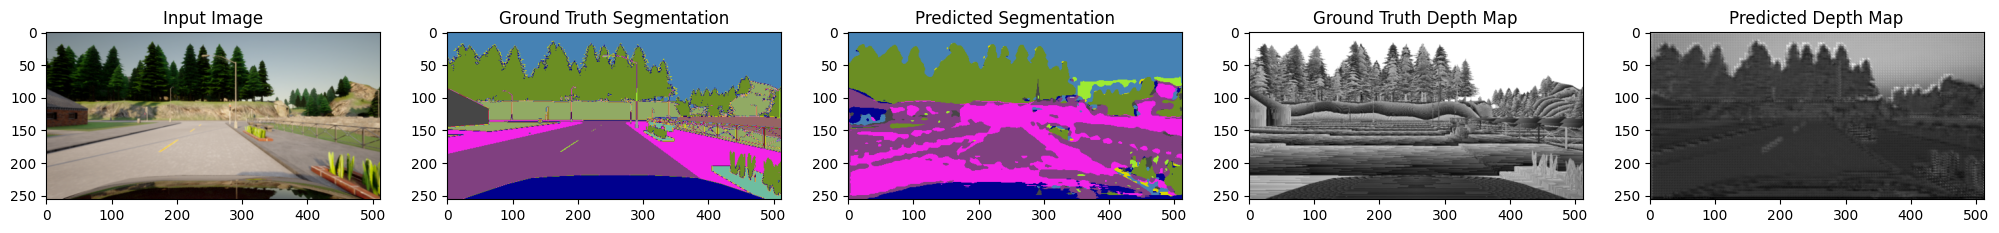

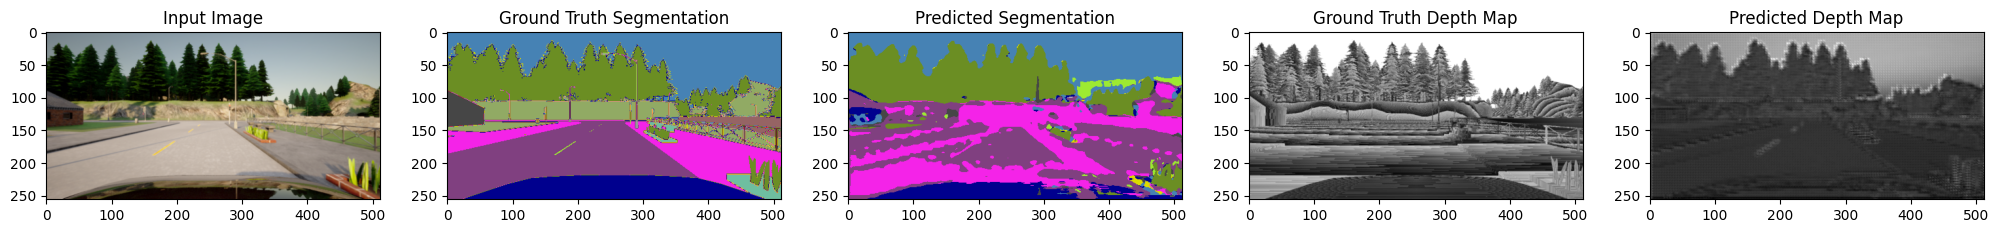

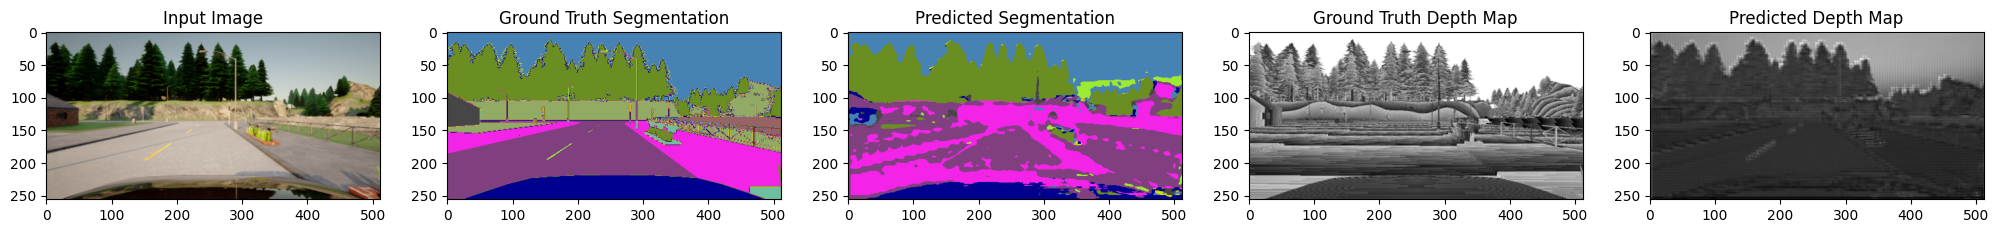

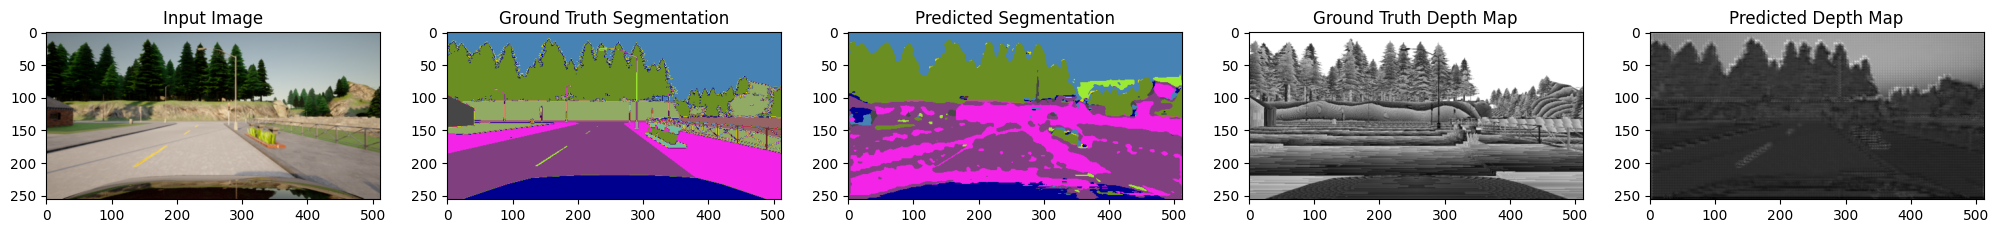

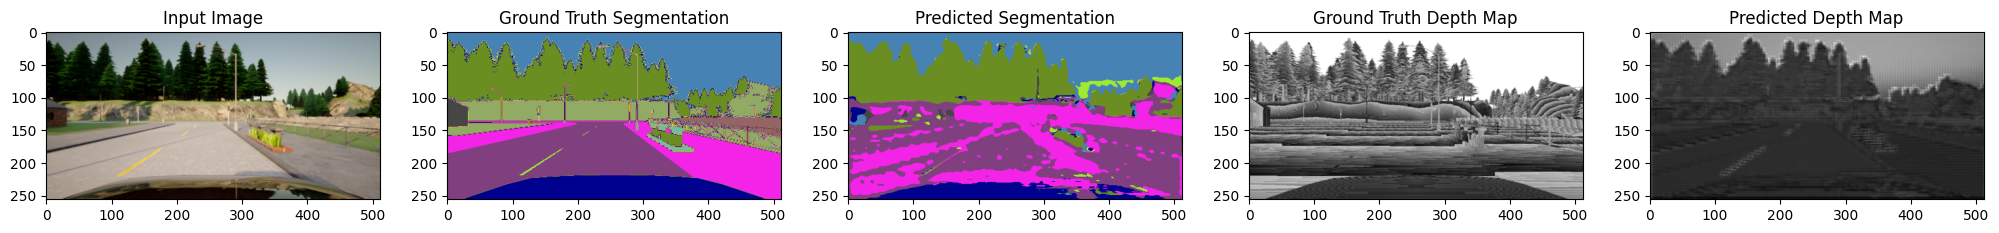

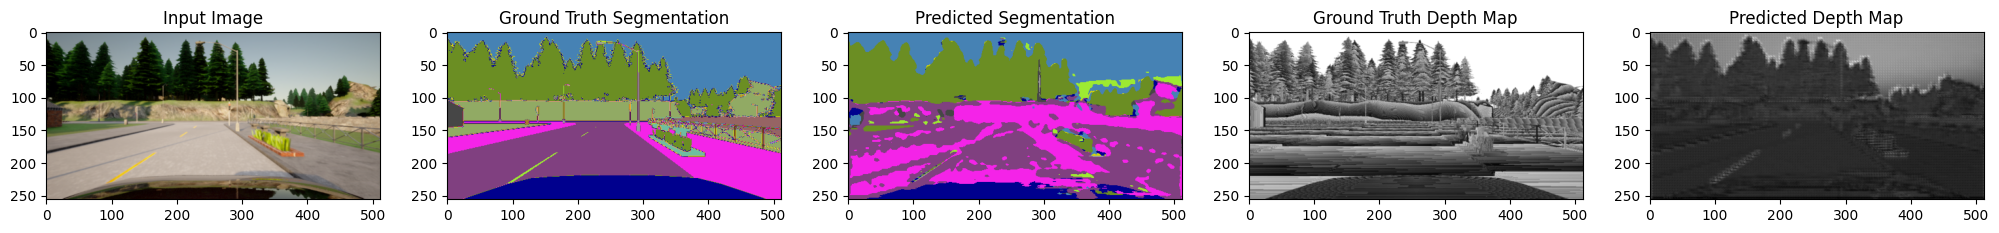

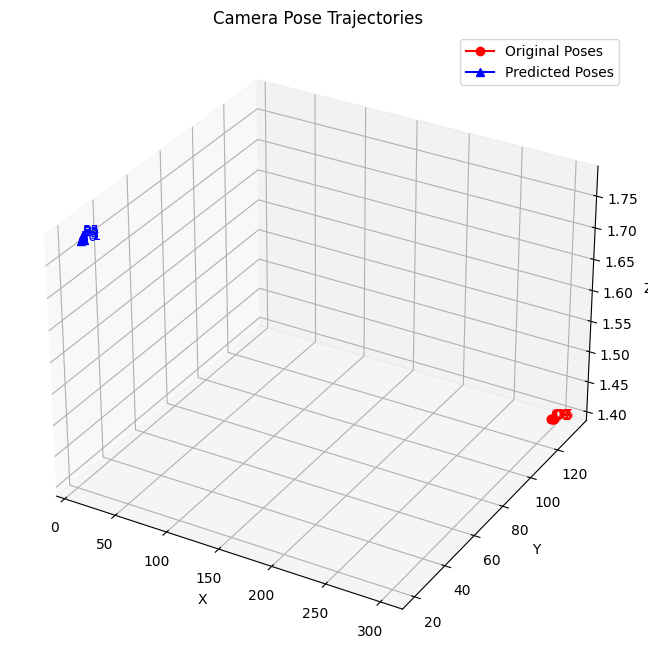

Visualizing pretraining:   0%|                                                                 | 0/8982 [00:10<?, ?it/s]


Visualizing predictions from the fine-tuned model...


Visualizing fine_tuning:   0%|                                                                 | 0/8982 [00:00<?, ?it/s]

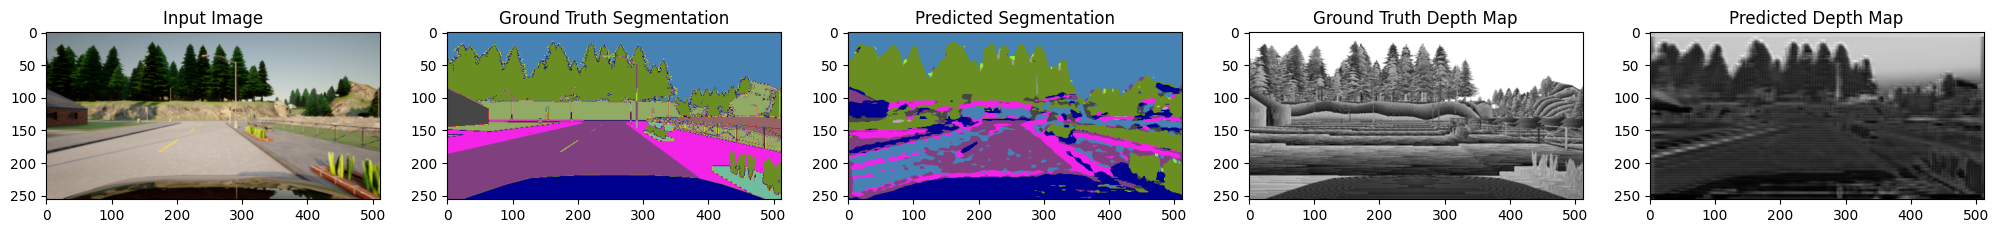

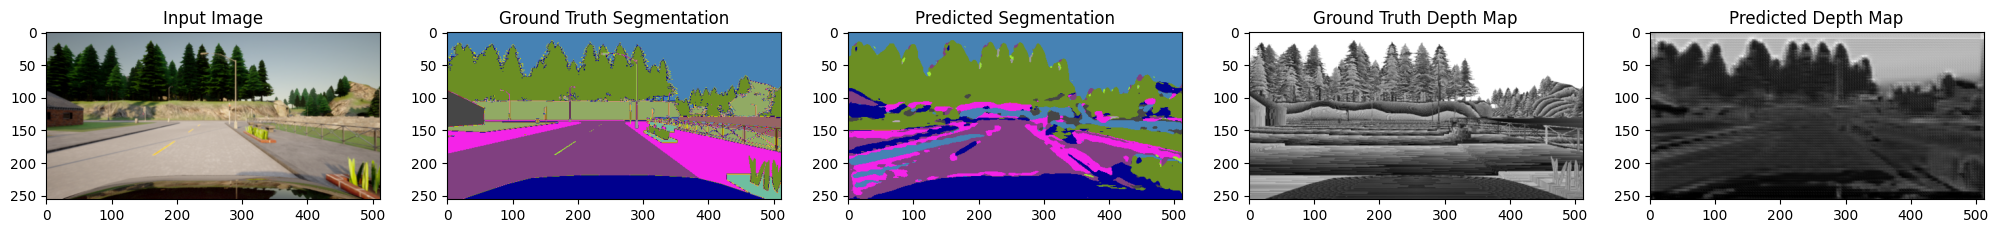

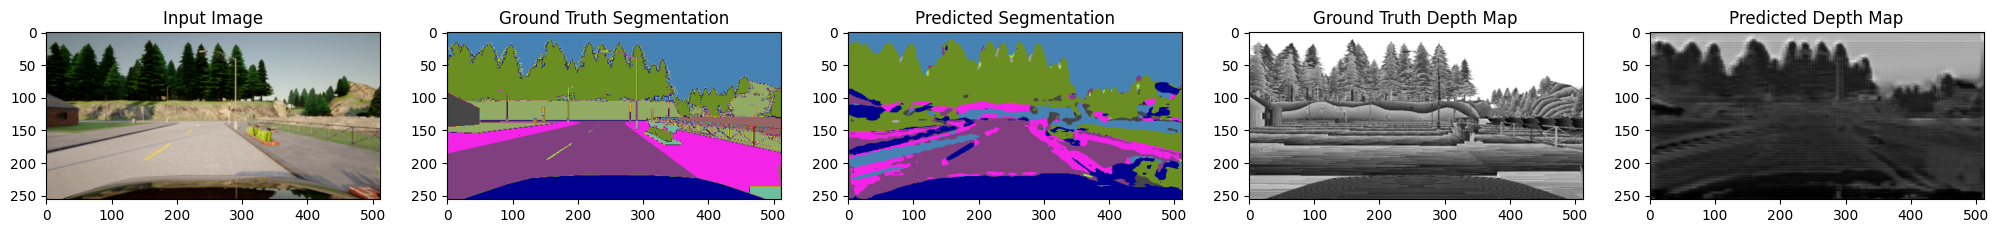

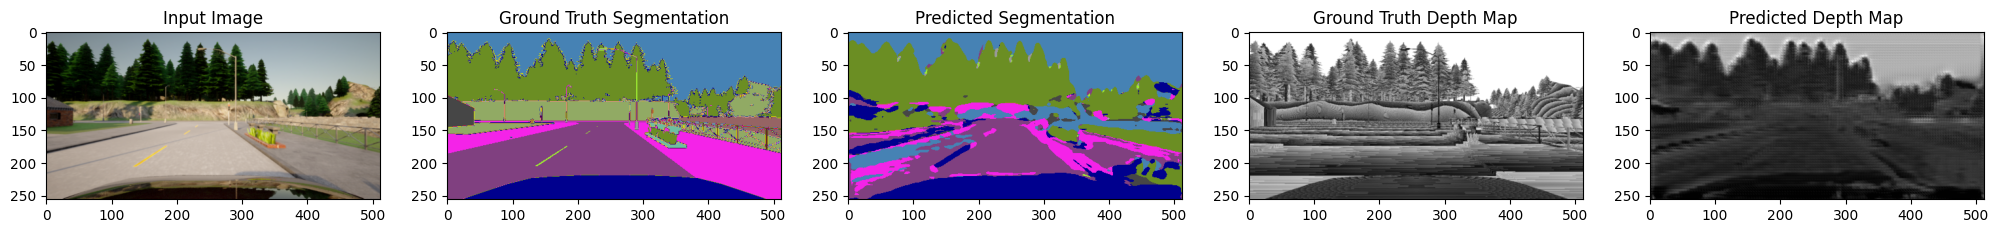

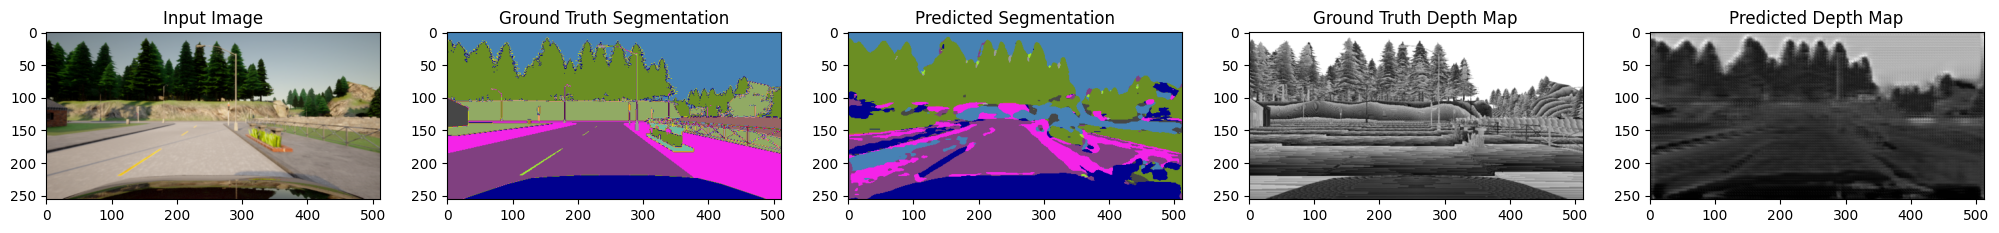

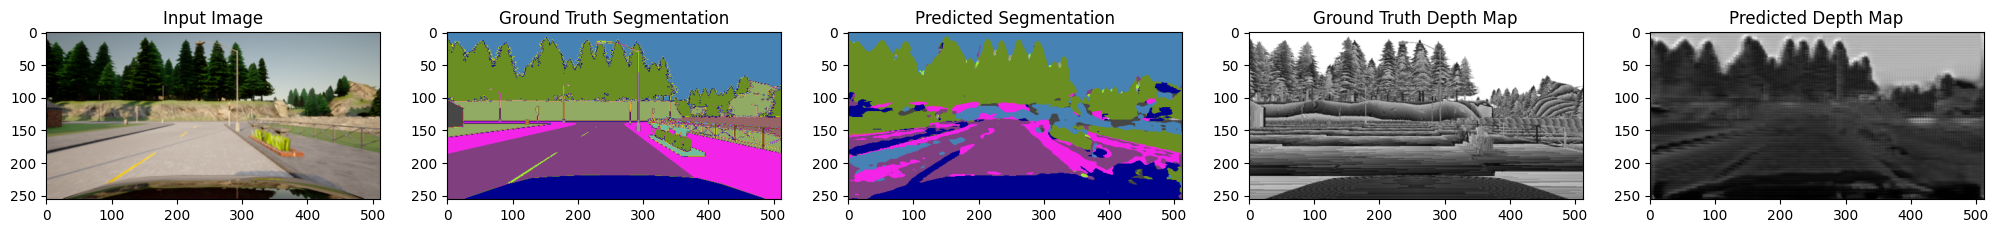

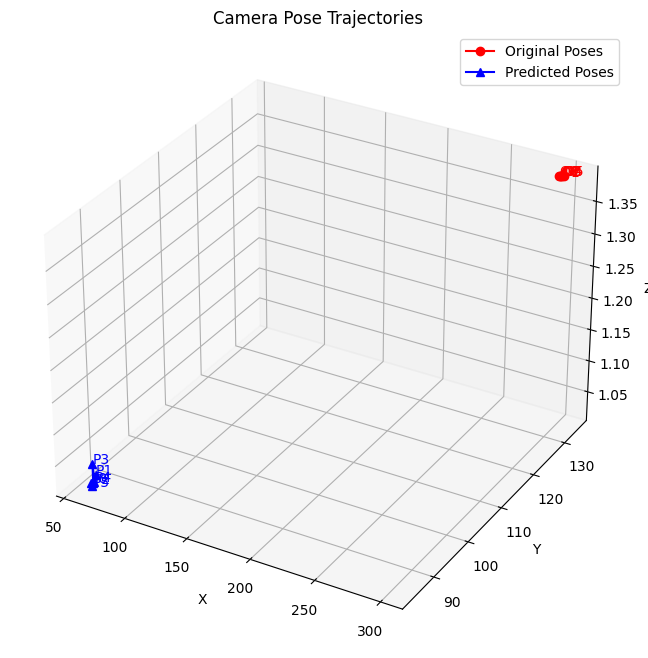

Visualizing fine_tuning:   0%|                                                                 | 0/8982 [00:08<?, ?it/s]


In [41]:
# Define paths to your model weights
pretrained_weights_path = 'Models/NoFilter/pretrained_weights.pth'
fine_tuned_weights_path = 'Models/NoFilter/fine_tuned_weights.pth'
GIF_path1 = "GIF/NoFilter/Pretrained"
GIF_path2 = "GIF/NoFilter/Finetuned"
# Initialize the Trainer
trainer = SegmentationModelTrainer(encoder, conv_lstm_model, depth_decoder, decoder, motion_encoder, camera_encoder, ego_motion_rnn, camera_decoder, org_train_loader, org_val_loader, train_loader, val_loader, criterion, Cam_criterion, Depth_criterian, optimizer, device)

# Function to load weights into the model
def load_weights(model_trainer, weights_path, mode):
    state = torch.load(weights_path, map_location=device)
    model_trainer.encoder.load_state_dict(state['encoder_state_dict'])
    model_trainer.depth_decoder.load_state_dict(state['depth_decoder_state_dict'])
    model_trainer.decoder.load_state_dict(state['decoder_state_dict'])
    model_trainer.motion_encoder.load_state_dict(state['motion_encoder_state_dict'])
    model_trainer.camera_encoder.load_state_dict(state['camera_encoder_state_dict'])
    model_trainer.camera_decoder.load_state_dict(state['camera_decoder_state_dict'])
    if mode == "fine_tuning":
        model_trainer.conv_lstm_model.load_state_dict(state['conv_lstm_state_dict'])
        model_trainer.ego_motion_rnn.load_state_dict(state['ego_motion_rnn_state_dict'])

# Function to visualize predictions for a given weights path and data loader
def visualize_predictions(model_trainer, weights_path, data_loader, mode):
    load_weights(model_trainer, weights_path, mode)
    model_trainer.switch_dataloader(mode)
    
    for sequence_batch, optical_flow_batch, segmentation_targets, extrinsics, depth_tensor in tqdm(data_loader, desc=f"Visualizing {mode}"):
        sequence_batch = sequence_batch.to(device)
        optical_flow_batch = optical_flow_batch.to(device)
        segmentation_targets = segmentation_targets.to(device)
        extrinsics = extrinsics.to(device)
        depth_tensor = depth_tensor.to(device)
        
        
        predicted_segmentation_labels, predicted_depth, camera_poses_scaled = model_trainer.forward_pass(
            sequence_batch, optical_flow_batch, extrinsics, mode
        )
        
        # Visualize predictions
        visualize_sequence_full(
            sequence_batch, segmentation_targets, predicted_segmentation_labels, depth_tensor, predicted_depth, device
        )
        
        # Camera Posses
        plot_camera_trajectories(extrinsics, camera_poses_scaled)
        
        # GIFs Saving
        input_images_sequence = []
        gt_segmentation_sequence = []
        predicted_segmentation_sequence = []
        gt_depth_maps_sequence = []
        predicted_depth_maps_sequence = []
        batch_size, sequence_length, c, h, w = sequence_batch.size()
        for i in range(sequence_length):  

            input_images_sequence.append(sequence_batch[0, i].permute(1, 2, 0).cpu().numpy())

            gt_segmap = decode_segmap(segmentation_targets[0, i].cpu().numpy())
            gt_segmentation_sequence.append(gt_segmap)

            pred_segmap = decode_segmap(predicted_segmentation_labels[i].cpu().numpy())
            predicted_segmentation_sequence.append(pred_segmap)

            gt_depth_map = depth_tensor[0, i].squeeze().cpu().numpy()
            if np.max(gt_depth_map) > 255 or np.min(gt_depth_map) < 0:
                gt_depth_map = (gt_depth_map - np.min(gt_depth_map)) / (np.max(gt_depth_map) - np.min(gt_depth_map))  # Normalizing to 0-1
            gt_depth_maps_sequence.append(gt_depth_map)

            predicted_depth_map = predicted_depth[0, i].squeeze().cpu().detach().numpy()
            if np.max(predicted_depth_map) > 255 or np.min(predicted_depth_map) < 0:
                predicted_depth_map = (predicted_depth_map - np.min(predicted_depth_map)) / (np.max(predicted_depth_map) - np.min(predicted_depth_map))  # Normalizing to 0-1
            predicted_depth_maps_sequence.append(predicted_depth_map)    
        if mode == "pretraining":
            save_gif(input_images_sequence, os.path.join(GIF_path1, 'input_images.gif'))
            save_gif(gt_segmentation_sequence, os.path.join(GIF_path1, 'gt_segmentation.gif'))
            save_gif(predicted_segmentation_sequence, os.path.join(GIF_path1, 'predicted_segmentation.gif'))
            save_gif(gt_depth_maps_sequence, os.path.join(GIF_path1, 'gt_depth_maps.gif'), duration=0.2)  
            save_gif(predicted_depth_maps_sequence, os.path.join(GIF_path1, 'predicted_depth_maps.gif'), duration=0.2)
        else:
            save_gif(input_images_sequence, os.path.join(GIF_path2, 'input_images.gif'))
            save_gif(gt_segmentation_sequence, os.path.join(GIF_path2, 'gt_segmentation.gif'))
            save_gif(predicted_segmentation_sequence, os.path.join(GIF_path2, 'predicted_segmentation.gif'))
            save_gif(gt_depth_maps_sequence, os.path.join(GIF_path2, 'gt_depth_maps.gif'), duration=0.2)  
            save_gif(predicted_depth_maps_sequence, os.path.join(GIF_path2, 'predicted_depth_maps.gif'), duration=0.2)
        
        break
# Visualize predictions for the pretrained model
print("Visualizing predictions from the pretrained model...")
visualize_predictions(trainer, pretrained_weights_path, trainer.org_train_loader, 'pretraining')

# Visualize predictions for the fine-tuned model
print("Visualizing predictions from the fine-tuned model...")
visualize_predictions(trainer, fine_tuned_weights_path, trainer.train_loader, 'fine_tuning')


<a id="7123-gifs"></a>
##### 7.1.2.3 GIFs

In [ ]:
GIF_path1 = "GIF/NoFilter/Pretrained"
GIF_path2 = "GIF/NoFilter/Finetuned"
def Show_gifs(path):
    gif_filenames = ['input_images.gif', 'gt_segmentation.gif', 'predicted_segmentation.gif', 'gt_depth_maps.gif', 'predicted_depth_maps.gif']
    gif_html = '<table><tr>'

    for gif in gif_filenames:
        gif_path = os.path.join(path, gif)
        gif_html += f'<td><img src="{gif_path}" alt="{gif}" style="width:160px;height:120px;"></td>'

    gif_html += '</tr></table>'

    HTML(gif_html)
    
print("PreTrained Results without Filters at BaseCARLA")
Show_gifs(GIF_path1)
print("Finetuned Results with filter and at CorruptedCARLA")
Show_gifs(GIF_path2)

<a id="713-training-validation-test-statistics"></a>
#### 7.1.3 Training, Validation, Test Statistics

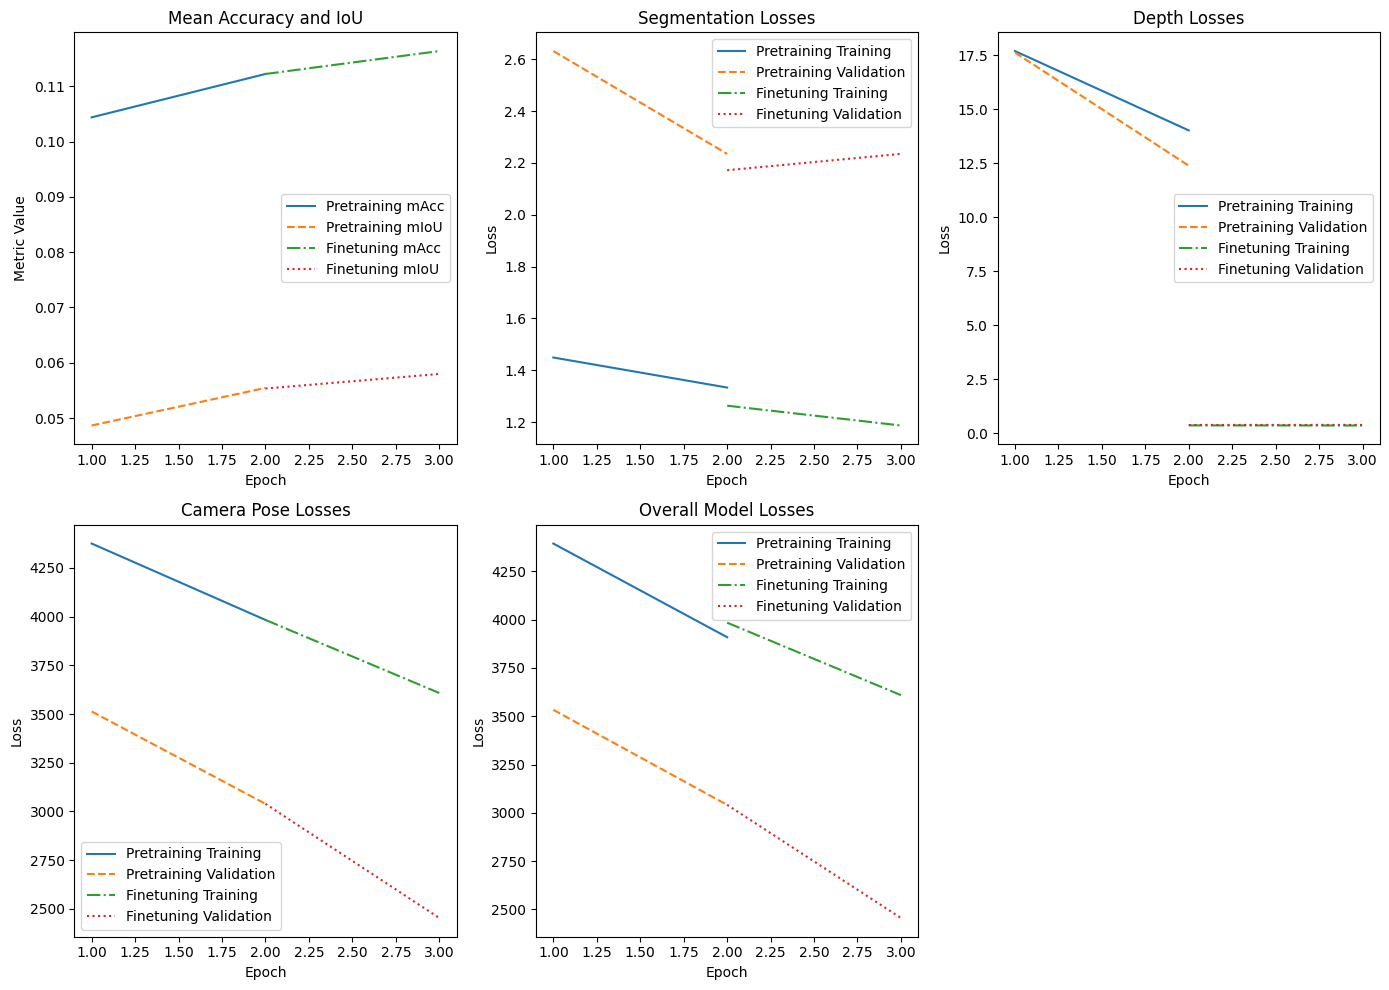

In [56]:
# merge in final code

import matplotlib.pyplot as plt
import json

# Load the pretraining and finetuning statistics from JSON
with open('Models/NoFilter/pretraining_stats.json', 'r') as f:
    pretraining_stats = json.load(f)

with open('Models/NoFilter/finetuning_stats_stats.json', 'r') as f:
    finetuning_stats = json.load(f)

# Assuming epochs based on the length of one of the lists
epochs_pretraining = range(1, len(pretraining_stats['seg_loss_list']) + 1)
epochs_finetuning = range(len(epochs_pretraining), len(epochs_pretraining) + len(finetuning_stats['fseg_loss_list']))

# Setting up the figure for plotting
plt.figure(figsize=(14, 10))

# Plot Mean Accuracy (mAcc) and Mean IoU for both pretraining and finetuning
plt.subplot(2, 3, 1)
plt.plot(epochs_pretraining, pretraining_stats['mAcc_list'], label='Pretraining mAcc')
plt.plot(epochs_pretraining, pretraining_stats['val_mIoU_list'], label='Pretraining mIoU', linestyle='--')
plt.plot(epochs_finetuning, finetuning_stats['fmAcc_list'], label='Finetuning mAcc', linestyle='-.')
plt.plot(epochs_finetuning, finetuning_stats['fval_mIoU_list'], label='Finetuning mIoU', linestyle=':')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Mean Accuracy and IoU')
plt.legend()

# Function to plot training vs. validation losses for both pretraining and finetuning
def plot_loss_subplot(subplot_index, title, pretraining_loss, pretraining_val_loss, finetuning_loss, finetuning_val_loss):
    plt.subplot(2, 3, subplot_index)
    plt.plot(epochs_pretraining, pretraining_stats[pretraining_loss], label='Pretraining Training')
    plt.plot(epochs_pretraining, pretraining_stats[pretraining_val_loss], label='Pretraining Validation', linestyle='--')
    plt.plot(epochs_finetuning, finetuning_stats[finetuning_loss], label='Finetuning Training', linestyle='-.')
    plt.plot(epochs_finetuning, finetuning_stats[finetuning_val_loss], label='Finetuning Validation', linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()

# Segmentation Losses
plot_loss_subplot(2, 'Segmentation Losses', 'seg_loss_list', 'seg_val_loss_list', 'fseg_loss_list', 'fseg_val_loss_list')

# Depth Losses
plot_loss_subplot(3, 'Depth Losses', 'depth_loss_list', 'depth_val_loss_list', 'fdepth_loss_list', 'fdepth_val_loss_list')

# Camera Pose Losses
plot_loss_subplot(4, 'Camera Pose Losses', 'cam_loss_list', 'cam_val_loss_list', 'fcam_loss_list', 'fcam_val_loss_list')

# Combined Model Losses
plot_loss_subplot(5, 'Overall Model Losses', 'total_loss_list', 'val_total_loss_list', 'ftotal_loss_list', 'fval_total_loss_list')

plt.tight_layout()
plt.show()
